In [2]:
import numpy

import constants
import rscha2d
import trig
import fibonacci_sphere
import coords
import gauge

from matplotlib import pyplot

%matplotlib nbagg

In [3]:
lat_c = 42.0
lon_c = 20.0
theta_c, phi_c, theta_0d, theta_0 = numpy.deg2rad((90-lat_c, lon_c, 26.0, 50.0))
knots_bd = numpy.arange(-2000, 2000, 50)

In [4]:
import importlib
importlib.reload(rscha2d)

model_bd = rscha2d.Model()
model_bd.set_model_params(theta_c, phi_c, theta_0d, 0.1, 3, 3, 2, knots=knots_bd,
                          temporal_reg=0, spatial_reg=10, g10_ref=-37)
model_bd.add_data("../data/rscha2d/bd_sha_orig_trim.dat")

In [31]:
l_points = 20
t_ls = numpy.logspace(-5, 4, l_points)
D_rms = numpy.empty(l_points)
I_rms = numpy.empty(l_points)
F_rms = numpy.empty(l_points)

D_nrms = numpy.empty(l_points)
I_nrms = numpy.empty(l_points)
F_nrms = numpy.empty(l_points)

a95 = model_bd.a95.copy()
a95[(~model_bd.nan_I | ~model_bd.nan_D) & numpy.isnan(a95)] = numpy.deg2rad(4.3)
F_err = model_bd.F_err.copy()
F_err[~model_bd.nan_F & numpy.isnan(F_err)] = 1.0

In [32]:
for i, t_lambda in enumerate(t_ls):
    
    model_bd.temporal_reg = t_lambda
    g_bd = model_bd.solve()
    D_rem_bd, I_rem_bd, F_rem_bd = model_bd.synth_data(model_bd.tv, model_bd.r_geo,
                                                   model_bd.theta_geo, model_bd.phi_geo, g_bd)
    D_rem_bd = trig.mindiff(D_rem_bd, 0)
    I_rem_bd = trig.mindiff(I_rem_bd, 0)

    
    D_res_bd = trig.mindiff(D_rem_bd, model_bd.D_o)[~model_bd.nan_D]
    D_nres_bd = D_res_bd / a95[~model_bd.nan_D]
    I_res_bd = trig.mindiff(I_rem_bd, model_bd.I_o)[~model_bd.nan_I]
    I_nres_bd = I_res_bd / a95[~model_bd.nan_I]
    F_res_bd = (F_rem_bd - model_bd.F_o)[~model_bd.nan_F]
    F_nres_bd = F_res_bd / F_err[~model_bd.nan_F]
    
    D_rms[i] = numpy.sqrt(numpy.average(D_res_bd**2))
    I_rms[i] = numpy.sqrt(numpy.average(I_res_bd**2))
    F_rms[i] = numpy.sqrt(numpy.average(F_res_bd**2))
    
    D_nrms[i] = numpy.sqrt(numpy.average(D_nres_bd**2))
    I_nrms[i] = numpy.sqrt(numpy.average(I_nres_bd**2))
    F_nrms[i] = numpy.sqrt(numpy.average(F_nres_bd**2))
    
    print(gauge.gauge(i+1, l_points), end="\r")

In [33]:
numpy.isnan(model_bd.F_err[~model_bd.nan_F]).sum()

10

<IPython.core.display.Javascript object>


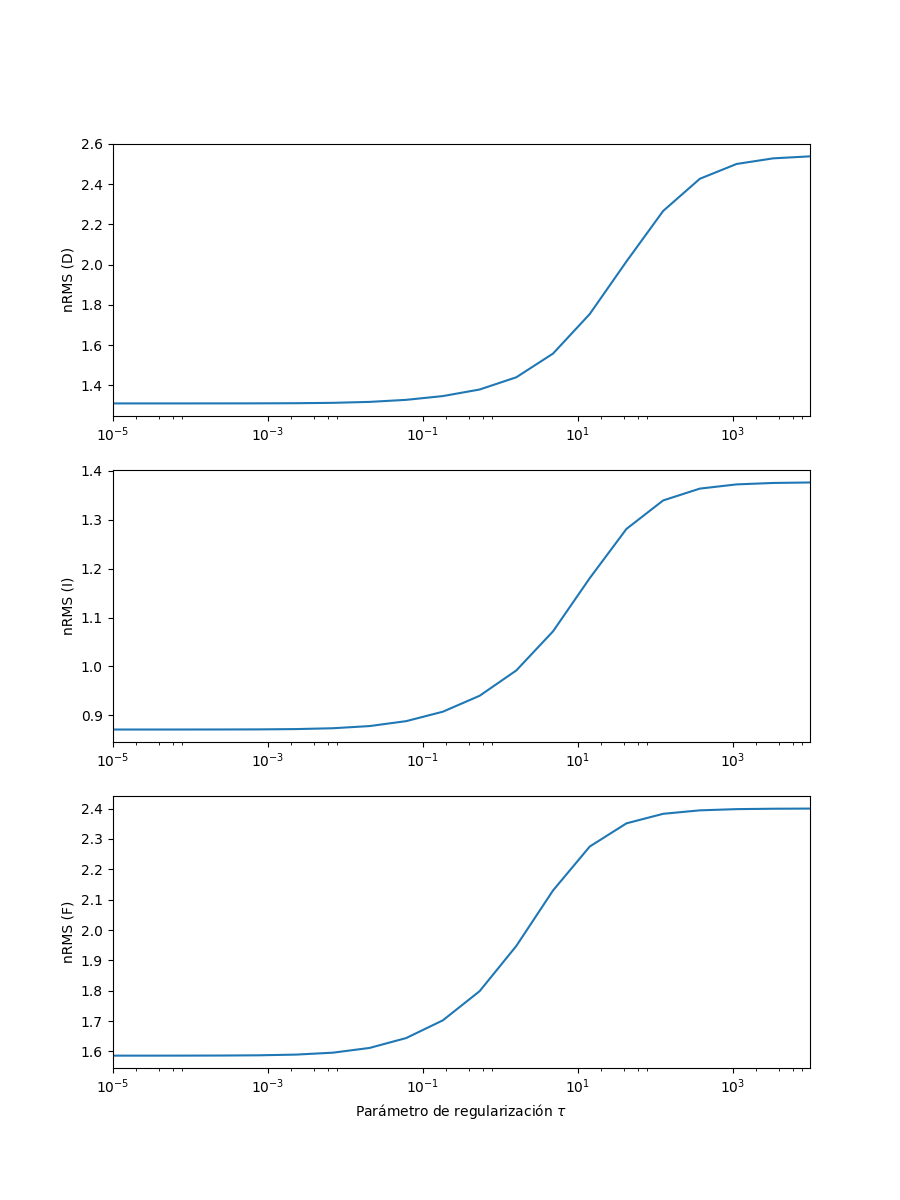

In [50]:
fig, (ax0, ax1, ax2) = pyplot.subplots(3,1, figsize=(9,12))

ax0.plot(t_ls, D_nrms)
ax1.plot(t_ls, I_nrms)
ax2.plot(t_ls, F_nrms)

ax0.set_ylabel("nRMS (D)")
ax1.set_ylabel("nRMS (I)")
ax2.set_ylabel("nRMS (F)")
ax2.set_xlabel(r"Parámetro de regularización $\tau $")

for ax in (ax0, ax1, ax2):
    ax.set_xscale("log")
    ax.set_xbound(numpy.min(t_ls), numpy.max(t_ls))